In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler


In [2]:
# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target'].astype(int)

# Convert the target to binary classification (Class -1 = 1, Class 1 = 7)
y_binary = np.where(y == 1, -1, np.where(y == 7, 1, 0))

# Filter out the non-1 and non-7 examples for binary classification
X_binary = X[y_binary != 0]
y_binary = y_binary[y_binary != 0]

# Split the data into training, validation, and test sets (60%, 20%, 20%)
X_train, X_temp, y_train, y_temp = train_test_split(X_binary, y_binary, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the data (important for SVMs)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [3]:
# Define the SVM model with RBF kernel
svm_model = SVC(kernel='rbf', random_state=42)

# Train the model using the training data
svm_model.fit(X_train_scaled, y_train)


SVC(random_state=42)

In [4]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': [0.01, 0.1, 1, 10]  # Kernel coefficient
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(SVC(kernel='rbf', random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
print(f"Best parameters: {grid_search.best_params_}")


Best parameters: {'C': 10, 'gamma': 0.01}


In [5]:
# Use the best model from grid search
best_model = grid_search.best_estimator_

# Make predictions on the validation set
y_val_pred = best_model.predict(X_val_scaled)

# Accuracy on validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate on the test set
y_test_pred = best_model.predict(X_test_scaled)

# Test Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")


Validation Accuracy: 0.970995385629532
Test Accuracy: 0.9620962425840475


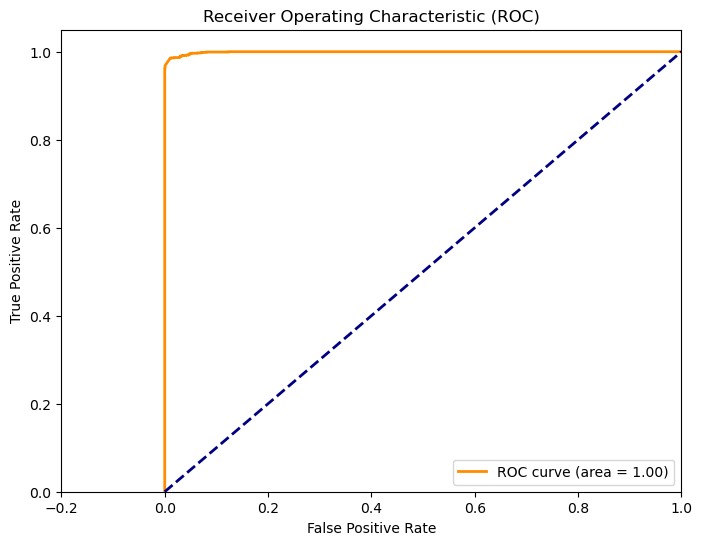

Per class accuracy: [0.93008739 0.99790503]


In [6]:
# AUROC (Area Under ROC Curve)
fpr, tpr, thresholds = roc_curve(y_test, best_model.decision_function(X_test_scaled))
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.2, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Per class accuracy (1 for class 7, -1 for class 1)
cm = confusion_matrix(y_test, y_test_pred)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
print(f"Per class accuracy: {per_class_accuracy}")


In [7]:
from sklearn.metrics import roc_auc_score

# Get decision scores for test set predictions
decision_scores = best_model.decision_function(X_test_scaled)

# Compute AUROC
auroc = roc_auc_score(y_test, decision_scores)
print(f"AUROC: {auroc:.4f}")


AUROC: 0.9992


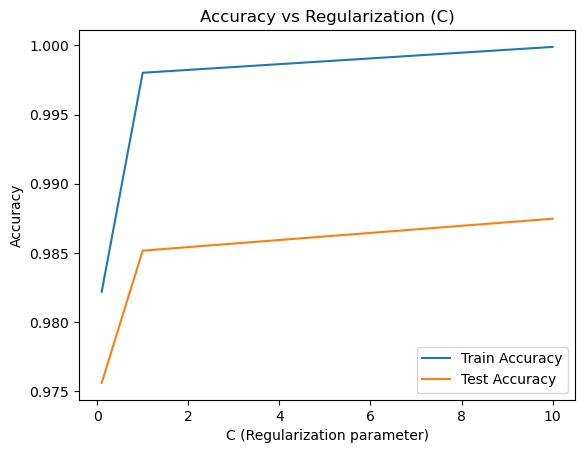

In [8]:
# Plot Training and Test Accuracy as a function of Regularization parameter 'C'
C_values = [0.1, 1, 10]
train_accuracies = []
test_accuracies = []

for C in C_values:
    model = SVC(kernel='rbf', C=C, random_state=42)
    model.fit(X_train_scaled, y_train)
    train_accuracies.append(accuracy_score(y_train, model.predict(X_train_scaled)))
    test_accuracies.append(accuracy_score(y_test, model.predict(X_test_scaled)))

plt.plot(C_values, train_accuracies, label='Train Accuracy')
plt.plot(C_values, test_accuracies, label='Test Accuracy')
plt.xlabel('C (Regularization parameter)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Regularization (C)')
plt.legend()
plt.show()


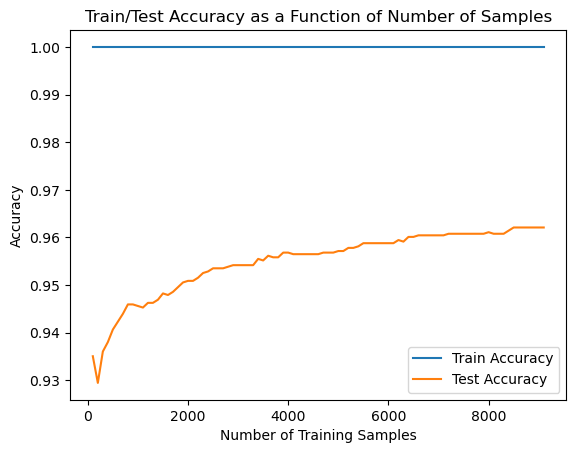

In [9]:
# Plot Train/Test Accuracy as a function of the number of samples
sample_sizes = np.arange(100, len(X_train_scaled), 100)
train_accs = []
test_accs = []

for size in sample_sizes:
    model = SVC(kernel='rbf', C=10, gamma=0.01, random_state=42)
    model.fit(X_train_scaled[:size], y_train[:size])
    train_accs.append(accuracy_score(y_train[:size], model.predict(X_train_scaled[:size])))
    test_accs.append(accuracy_score(y_test, model.predict(X_test_scaled)))

plt.plot(sample_sizes, train_accs, label='Train Accuracy')
plt.plot(sample_sizes, test_accs, label='Test Accuracy')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.title('Train/Test Accuracy as a Function of Number of Samples')
plt.legend()
plt.show()
